In [1]:
import nanomotif as nm
import logging as log
log.getLogger().setLevel(log.DEBUG)
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
padding = 12


In [2]:
import re


# Intro

Documentation of considerations in the implementation of the candidate selection. 

The selection is based on the sequences around methylation sites on the contig. At each methylated position, a frame of n posiion on each side of the methylation side is extracted and the index within this subsequence is considered relative to the methylation position (range: -n to n or 0:n*2).

The initial approach for candidate selection is outlined here:

1. Sample random sequences in contig at canonical bases (e.g. A when 6mA i evaluated)
2. Calculate [PSSM](https://cs.rice.edu/~ogilvie/comp571/pssm/) (positional frequencies of bases) for contig sequences
3. Extract sequences in contig at all methylation sites
4. Set motif candidate to canonical base
2. While len(methylations sequences) > minimum sequences 
    - calculate PSSM for methylations sequences
    - Calculate KL-divergence from methylation PSSM to contig PSSM at each position
    - Select position in sequence with highest distance
    - Select most frequent base at this position
    - Add base to motif
    - Score new motif
    - if score > threshold
        - remove seuqences with motif from methylation sequences
        - keep motif
    - else
        - select sequences with motif from methylation sequences

This should grow a motif by incorporation the most informative positions and bases first. 

In [3]:
ec_assembly = nm.load_assembly("../data/ecoli/assembly.polished.fasta")
ec_pileup = nm.load_pileup("../data/ecoli/modkit.pileup.bed")

In [9]:
ec_motifs = nm.evaluate.process_sample(
    ec_assembly, 
    ec_pileup.pileup, 
    min_read_methylation_fraction = 0.7,
    min_valid_coverage = 10,
    min_kl_divergence = 0.2
)


INFO:root:Processing contig_3 a
DEBUG:root:....................A.................... | BetaBernoulliModel(alpha=45701, beta=2237716) | 0.00 | 0
DEBUG:root:....................A.C.................. | BetaBernoulliModel(alpha=40196, beta=567600) | 0.01 | 0
DEBUG:root:....................ATC.................. | BetaBernoulliModel(alpha=38438, beta=134620) | 0.10 | 0
DEBUG:root:...................GATC.................. | BetaBernoulliModel(alpha=38064, beta=185) | 2.65 | 0
DEBUG:root:...................GATC.................., 38062 seqs. model: BetaBernoulliModel(alpha=38064, beta=185). (16.7 % left)
DEBUG:root:Continuing search
DEBUG:root:....................A.................... | BetaBernoulliModel(alpha=45701, beta=2237716) | 0.00 | 0
DEBUG:root:...................CA.................... | BetaBernoulliModel(alpha=4372, beta=643096) | -0.00 | 0
DEBUG:root:...................CA[GC]................... | BetaBernoulliModel(alpha=3851, beta=325406) | 0.00 | 2
DEBUG:root:...................C

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f2d829ed2e0>


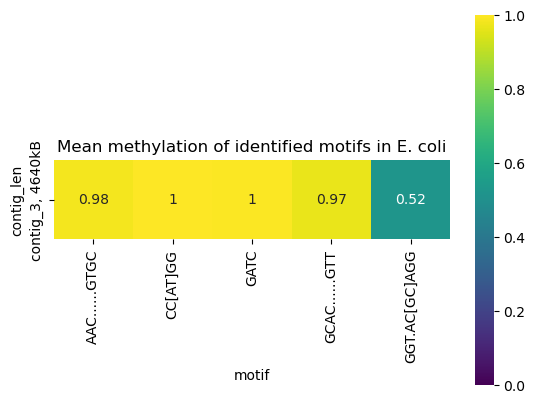

In [15]:
ec_motifs = nm.postprocess.remove_sub_motifs(ec_motifs)
ec_motifs = nm.postprocess.remove_noisy_motifs(ec_motifs)
ec_motifs_plot = ec_motifs \
    .with_columns([
        pl.col("model").apply(lambda model: model.mean()).alias("mean"),
        pl.col("contig").apply(lambda 
                               contig: f"{contig}, {len(ec_assembly.assembly[contig])/ 1e3:.0f}kB").alias("contig_len"),
    ]).sort("motif", descending = True)
heatmap = sns.heatmap(ec_motifs_plot.to_pandas().pivot(values = "mean", index = "contig_len", columns = "motif"), 
                      cmap = "viridis", square=True, vmin = 0.0, vmax = 1.0, annot = True);
heatmap.set_facecolor('lightgray');
plt.title("Mean methylation of identified motifs in E. coli");
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90);

# M. ruber

In [6]:
mr_assembly = nm.load_assembly("../data/mruber/assembly.polished.fasta")
mr_pileup = nm.load_pileup("../data/mruber/modkit.pileup.bed")

In [36]:

from matplotlib import cm
def plot_dna_sequences(sequences, cm_palette: str = "Pastel2"):
    """
    Function to plot DNA sequences with a consensus sequence.
    
    Parameters:
    sequences (list): A list of DNA sequences to be plotted.
    cm_palette (str): A color palette to use for the plot, default is "Pastel2".

    Returns:
    None
    
    The function will plot DNA sequences in a form of heatmap and add a consensus sequence at the bottom. 
    The x-axis represents the position in the sequence, and the y-axis represents individual sequences and the consensus.

    >>> sequences = ['ATGCGAC', 'ATTCGAC', 'ATGCGAT', 'ATGCGAC']
    >>> plot_dna_sequences(sequences)
    <Axes: >
    """
    
    # Create SequenceEnrichment and append consensus sequence
    n_seqs, n_bases = len(sequences.sequences), max([len(seq) for seq in sequences.sequences])
    
    # Generate labels for sequences
    y_tick_labels = [f"Seq {i}" for i in range(n_seqs-1)]

    # Create 2D array of sequences
    sequences_array = sequences.convert_to_DNAarray()
    
    # Calculate font size
    font_size = 15

    # Create plot
    fig, ax = plt.subplots(figsize=(2 + n_bases*.28, 1 + n_seqs*.20));
    ax.imshow(sequences_array, cmap=getattr(cm, cm_palette));

    # Set labels for y axis
    ax.set_yticks(np.arange(n_seqs-1));
    ax.set_yticklabels(y_tick_labels, fontsize=font_size, fontweight="bold");

    # Loop over data dimensions and create text annotations
    for i in range(n_seqs):
        for j in range(n_bases):
            if j == n_bases//2:
                ax.text(j, i, sequences.sequences[i][j], ha="center", va="center", color="green", 
                        fontsize=font_size, fontweight="bold");
            else:
                ax.text(j, i, sequences.sequences[i][j], ha="center", va="center", color="black", 
                        fontsize=font_size);
    
    # Draw line to separate consensus from sequences
    ax.axhline(y=n_seqs-1.5, color="black", linewidth=1);
    
    # Adjust plot layout and display
    fig.tight_layout()

    return ax


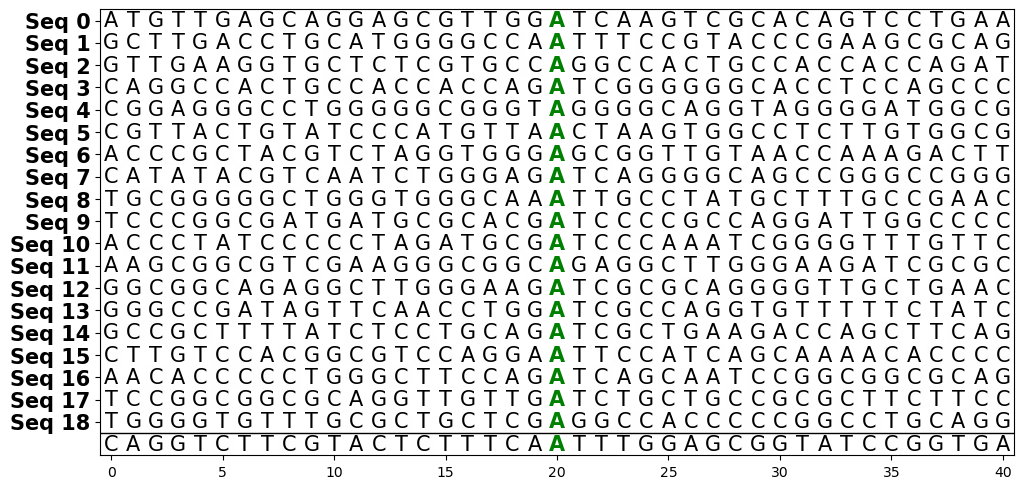

In [38]:
mod_pos = mr_pileup.pileup.filter(pl.col("fraction_mod") > 0.8).filter(pl.col("mod_type") == "a").filter(pl.col("strand") == "+").get_column("position").to_list()
mod_seqs = mr_assembly.assembly["contig_1"].sample_at_indices(mod_pos, padding = 20)
plot_dna_sequences(mod_seqs[0:20], cm_palette="Pastel2");

In [12]:
mr_motifs = nm.evaluate.process_sample(mr_assembly, mr_pileup.pileup.filter(pl.col("mod_type")=="a"), 
    min_read_methylation_fraction = 0.8,
    min_valid_coverage = 5,
    min_kl_divergence = 0.2
    )

INFO:root:Processing contig_1 a
DEBUG:root:....................A.................... | BetaBernoulliModel(alpha=43533, beta=1090692) | 0.00 | 0
DEBUG:root:...................GA.................... | BetaBernoulliModel(alpha=29522, beta=285238) | 0.02 | 0
DEBUG:root:...................GA[TG]................... | BetaBernoulliModel(alpha=28677, beta=142812) | 0.04 | 2
DEBUG:root:...................GA[TG]C.................. | BetaBernoulliModel(alpha=20734, beta=38932) | 0.17 | 2
DEBUG:root:...................GAT................... | BetaBernoulliModel(alpha=13988, beta=58823) | 0.05 | 2
DEBUG:root:...................GATC.................. | BetaBernoulliModel(alpha=13544, beta=5875) | 0.87 | 2
DEBUG:root:..................TGATC.................. | BetaBernoulliModel(alpha=4684, beta=532) | 0.43 | 4
DEBUG:root:..................[TC]GATC.................. | BetaBernoulliModel(alpha=9028, beta=1113) | 0.43 | 6
DEBUG:root:..................CGATC.................. | BetaBernoulliModel(alpha=4

In [13]:
motifs = [nm.candidate.Motif(seq, pos) for seq, pos in zip(mr_motifs.get_column("motif"), mr_motifs.get_column("mod_position"))]
nm.candidate.remove_child_motifs(motifs)

AttributeError: 'Motif' object has no attribute 'child_of'

In [ ]:
mr_motifs

In [ ]:
mr_motifs_plot = mr_motifs \
    .with_columns([
        pl.col("model").apply(lambda model: model.mean()).alias("mean"),
        pl.col("contig").apply(lambda contig: f"{contig}, {len(mr_assembly.assembly[contig])/ 1e3:.0f}kB").alias("contig_len"),
    ]).sort("motif", descending = True)
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(mr_motifs_plot.to_pandas().pivot(values = "mean", index = "contig_len", columns = "motif"), 
                      cmap = "viridis", square=True, vmin = 0, vmax = 1, annot = True);
heatmap.set_facecolor('lightgray');
plt.title("Mean methylation of identified motifs in M. ruber");

# Geobacillus

In [ ]:
gb_assembly = nm.load_assembly("../data/geobacillus/assembly.polished.fasta")
gb_pileup = nm.load_pileup("../data/geobacillus/modkit.pileup.bed")

In [ ]:
assm_lengths = pl.DataFrame({
    "contig":[id for id, seq in gb_assembly.assembly.items()],
    "length":[len(seq) for id, seq in gb_assembly.assembly.items()]
})
assm_lengths

In [ ]:
gb_pileup.pileup \
        .filter(pl.col("fraction_mod") > 0.8) \
        .groupby(["contig", "mod_type"]) \
        .agg(pl.count()) \
        .join(assm_lengths, on = "contig") \
        .filter(pl.col("count") > pl.col("length")/10000)\
        .get_column("contig").unique().to_list()

In [ ]:
contigs_with_mods = gb_pileup.pileup.groupby("contig") \
    .agg(pl.count()) \
    .filter(pl.col("count") > 5000000) \
    .get_column("contig").to_list()
contigs_to_process = [contig for contig in gb_assembly.assembly.keys() if contig in contigs_with_mods]
gb_pileup.pileup.filter(pl.col("contig").is_in(contigs_with_mods))

In [ ]:
gb_motifs = nm.evaluate.process_sample(gb_assembly, gb_pileup.pileup.filter(pl.col("mod_type") == "a"), max_candidate_size = 30, min_valid_coverage=1 ,min_kl_divergence=0.2, min_read_methylation_fraction = 0)

In [ ]:
gb_motifs

In [ ]:
log.basicConfig(level=log.INFO);
gb_motifs_plot = gb_motifs \
    .with_columns([
        pl.col("model").apply(lambda model: model.mean()).alias("mean"),
        pl.col("contig").apply(lambda contig: f"{contig}, {len(gb_assembly.assembly[contig])/ 1e3:.0f}kB").alias("contig_len"),
        (pl.col("motif") + pl.col("mod_position").cast(pl.Utf8)).alias("motif_position")
    ]).sort("motif", descending = True)
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(gb_motifs_plot.to_pandas().pivot(values = "mean", index = "contig_len", columns = "motif_position"), 
                      cmap = "viridis", square=True, vmin = 0, vmax = 1, annot = True);
heatmap.set_facecolor('lightgray')
plt.title("Mean methylation of identified motifs in Geobacillus");

# E. coli -dcm/-dam

In [ ]:
ecneg_assembly = nm.load_assembly("../data/ecoli_neg/assembly.polished.fasta")
ecneg_pileup = nm.load_pileup("../data/ecoli_neg/modkit.pileup.bed")

In [ ]:
ecneg_assembly.assembly.keys()

In [ ]:
ecneg_motifs = nm.evaluate.process_sample(ecneg_assembly, ecneg_pileup.pileup, min_read_methylation_fraction = 0)

# Combining results

In [ ]:
assemblies = {
    "E. coli K12": ec_assembly,
    "E. coli -dam/-dcm": ecneg_assembly,
    "Geobacillus": gb_assembly,
    "M. ruber": mr_assembly
}
pileups = {
    "E. coli K12": ec_pileup,
    "E. coli -dam/-dcm": ecneg_pileup,
    "Geobacillus": gb_pileup,
    "M. ruber": mr_pileup
}

In [ ]:
all_motifs = pl.concat([ec_motifs, mr_motifs, gb_motifs])
all_motifs_scored = {
    "sample":[],
    "contig":[],
    "type":[],
    "motif":[],
    "model":[],
    "mean":[],
    "score":[],
    "contig_length":[],
    "mod_position":[]
}
for sample, assembly in assemblies.items():

    pileup_filt = pileups[sample].pileup.filter(pl.col("Nvalid_cov") > 5) \
        .filter(pl.col("fraction_mod") > 0.80)
    for contig, contig_sequence in assembly.assembly.items():
        print(contig)
        pileup_filt_contig = pileup_filt.filter(pl.col("contig") == contig)
        for row in all_motifs.rows():
            print(row[-2])
            model = nm.evaluate.score_candidate(
                pileup_filt_contig.filter(pl.col("mod_type") == row[-3]),
                contig_sequence.sequence,
                row[-2],
                row[-1]
            )
            all_motifs_scored["sample"].append(sample)
            all_motifs_scored["contig"].append(contig)
            all_motifs_scored["motif"].append(row[-2])
            all_motifs_scored["model"].append(model)
            all_motifs_scored["mean"].append(model.mean())
            all_motifs_scored["score"].append(1 - model.cdf(0.55))
            all_motifs_scored["type"].append(row[-3])
            all_motifs_scored["contig_length"].append(len(contig_sequence.sequence))
            all_motifs_scored["mod_position"].append(row[-1])
all_motifs_scored

In [ ]:
motifs_all_samples = pl.DataFrame(all_motifs_scored) \
.with_columns(
    (pl.col("sample") + "\n" + (pl.col("contig_length")/1e3).cast(pl.Int16).cast(pl.Utf8) + "kb").alias("id"),
    (pl.col("motif") + "_" + pl.col("type")+ "_" + pl.col("mod_position").cast(pl.Utf8)).alias("motif_mod_type")
)
motifs_all_samples

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True, light=.8)
heatmap = sns.clustermap(
    motifs_all_samples.to_pandas().reset_index().drop_duplicates(subset=['id', 'motif_mod_type'], keep='last').pivot(values = "score", index = "id", columns = "motif_mod_type"), 
    cmap = "viridis", vmin = 0, vmax = 1,
    row_cluster=True, col_cluster=True, dendrogram_ratio=0.15, figsize = (8, 8));
heatmap.ax_heatmap.yaxis.set_ticklabels(heatmap.ax_heatmap.yaxis.get_ticklabels(), rotation=0, ha='left');

In [ ]:
motifs_all_samples

In [ ]:
motifs_all_samples \
        .to_pandas().reset_index().drop_duplicates(subset=['id', 'motif_mod_type'], keep='last') \
        .pivot(values = "mean", index = "id", columns = "motif_mod_type")

In [ ]:
sns.heatmap(
    motifs_all_samples \
        .to_pandas().reset_index().drop_duplicates(subset=['id', 'motif_mod_type'], keep='last') \
        .pivot(values = "mean", index = "id", columns = "motif_mod_type"),
    cmap="viridis",
    annot = True,
    square = True)

In [ ]:

cm_plot = sns.clustermap(
    motifs_all_samples \
        .with_columns(
            pl.col("mean").round(1).alias("mean_rounded")
        )
        .to_pandas().reset_index().drop_duplicates(subset=['id', 'motif_mod_type'], keep='last') \
        .pivot(values = "mean_rounded", index = "id", columns = "motif_mod_type"),
    cmap="viridis",
    tree_kws={"linewidths": 0.},
    cbar_kws={"label": "Degree of methylation"},
    cbar_pos=(0.84, 0.31, 0.014, 0.52),
    vmin=0,
    vmax=1,
    figsize=(10, 6),
    annot=True
    );
cm_plot.ax_heatmap.set_xlabel("motif, type, modifed position")
cm_plot.ax_heatmap.set_ylabel("")
cm_plot.ax_heatmap.yaxis.tick_left()